Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


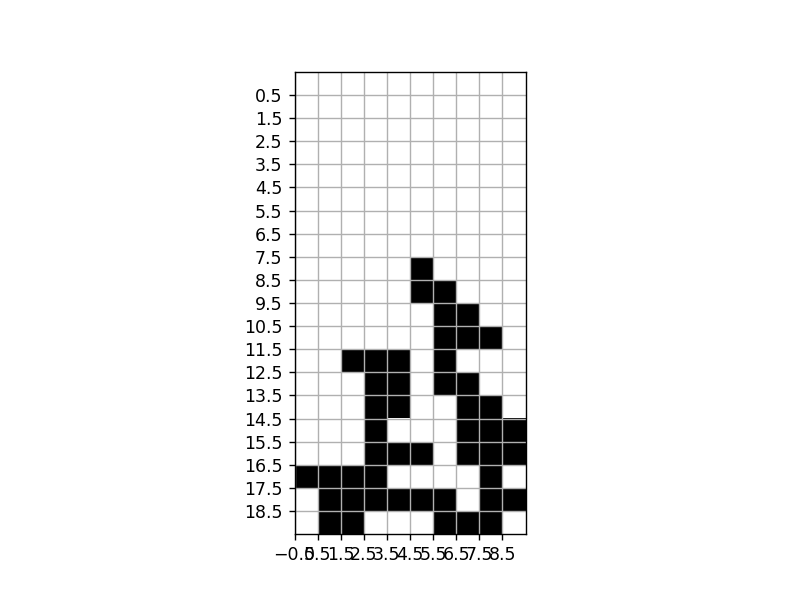

KeyboardInterrupt: 

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%matplotlib notebook


# GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BOARD_WIDTH = 10
BOARD_HEIGHT = 20
BLANK = 0

TEMPLATE_WIDTH = 5
TEMPLATE_HEIGHT = 5

S_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '..OO.',
                     '.OO..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '...O.',
                     '.....']]

Z_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '.O...',
                     '.....']]

I_SHAPE_TEMPLATE = [['..O..',
                     '..O..',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     'OOOO.',
                     '.....',
                     '.....']]

O_SHAPE_TEMPLATE = [['.....',
                     '.....',
                     '.OO..',
                     '.OO..',
                     '.....']]

J_SHAPE_TEMPLATE = [['.....',
                     '.O...',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..OO.',
                     '..O..',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '...O.',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '.OO..',
                     '.....']]

L_SHAPE_TEMPLATE = [['.....',
                     '...O.',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..O..',
                     '..OO.',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '.O...',
                     '.....'],
                    ['.....',
                     '.OO..',
                     '..O..',
                     '..O..',
                     '.....']]

T_SHAPE_TEMPLATE = [['.....',
                     '..O..',
                     '.OOO.',
                     '.....',
                     '.....'],
                    ['.....',
                     '..O..',
                     '..OO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '.....',
                     '.OOO.',
                     '..O..',
                     '.....'],
                    ['.....',
                     '..O..',
                     '.OO..',
                     '..O..',
                     '.....']]

PIECES = {'S': S_SHAPE_TEMPLATE,
          'Z': Z_SHAPE_TEMPLATE,
          'J': J_SHAPE_TEMPLATE,
          'L': L_SHAPE_TEMPLATE,
          'I': I_SHAPE_TEMPLATE,
          'O': O_SHAPE_TEMPLATE,
          'T': T_SHAPE_TEMPLATE}

PIECES_IND = {'S': 0,
              'Z': 1,
              'J': 2,
              'L': 3,
              'I': 4,
              'O': 5,
              'T': 6}

PIECES_MARGINS = {'S': [[1,1,0],[0,1,1]],
                  'Z': [[1,1,0],[1,0,1]],
                  'J': [[1,1,1],[0,1,1],[1,1,0],[1,0,1]],
                  'L': [[1,1,1],[0,1,1],[1,1,0],[1,0,1]],
                  'I': [[0,0,2],[2,1,0]],
                  'O': [[1,0,0]],
                  'T': [[1,1,1],[0,1,1],[1,1,0],[1,0,1]]}

class Tetris:
    def __init__(self):
        self.board = self.getBlankBoard()
        self.current_piece = self.getNewPiece()

    def reset(self):
        """
        Restarts the game with a blank board and new piece.
        Returns: torch tensor
            A tensor representing the state.

        """
        self.board = self.getBlankBoard()
        self.current_piece = self.getNewPiece()
        return self.convertToFeatures()

    def isOnBoard(self, x, y):
        """
        Checks if the position (x,y) is on the board.
        Args:
            x: int
                The x position
            y: int
                The y position

        Returns: Boolean
            If (x,y) is on the board.

        """
        return 0<=x<BOARD_WIDTH and 0<=y<BOARD_HEIGHT

    def getBlankBoard(self):
        return np.zeros((BOARD_WIDTH, BOARD_HEIGHT))

    def isValidPosition(self, x, y, rotation):
        """
        Checks if a piece has a valid position on the board.
        Args:
            shape: str
                The shape of the tetris piece.
            x: int
                The x position of the piece.
            y: int
                The y position of the piece.
            rotation: int
                The rotation of the piece.

        Returns: Boolean
            If the piece has a valid position on the board.

        """
        shape = self.current_piece
        for dx in range(TEMPLATE_WIDTH):
            for dy in range(TEMPLATE_HEIGHT):
                template = PIECES[shape][rotation % len(PIECES[shape])]
                if template[dy][dx] == 'O':
                    board_x_pos, board_y_pos = x + (dx - 2), y - (dy - 2)
                    if not self.isOnBoard(board_x_pos, board_y_pos) or self.board[board_x_pos][board_y_pos]:
                        return False
        return True

    def getNewPiece(self):
        return random.choice(list(PIECES.keys()))

    def getNextState(self, action):
        """
        Returns the next state given the current action.
        Args:
            action: int
                An integer representing the action chosen.
                In total, there are BOARD_WIDTH x 4 actions, representing
                choices in the x coordinate and rotation of the piece.
                For a chosen x and rotation r, the action is 4 * x + r.

        Returns: tuple
            A tuple (reward, next_state, done) representing the reward, next state,
            and if the game has finished.

        """
        rotation = action % 4
        left_margin, right_margin, top_margin = PIECES_MARGINS[self.current_piece][rotation % len(PIECES_MARGINS[self.current_piece])]
        x = max(left_margin, min(action // 4, BOARD_WIDTH - right_margin - 1))
        
        # Finding y coordinate to place the piece
        valid_y = None
        flag = False
        for y in range(BOARD_HEIGHT-top_margin-1, -2, -1):
            if self.isValidPosition(x, y, rotation):
                flag = True
            else:
                if flag:
                    valid_y = y + 1
                break
        
        if valid_y != None:
            self.placeOnBoard(x, valid_y, rotation)

            lines_cleared = self.clearLines()
            #delta_r, delta_c = self.countHoles()
            #reward = lines_cleared**2/16
                    #- delta_r/(BOARD_HEIGHT*BOARD_WIDTH) - delta_c/(BOARD_HEIGHT*BOARD_WIDTH))/2
            reward = lines_cleared**2/16

            self.current_piece = self.getNewPiece()
            next_state = self.convertToFeatures()
            return reward, next_state, False, lines_cleared
        

        return -1, None, True, 0

    def placeOnBoard(self, x, y, rotation):
        """
        Places the current piece on the board. Assumes that the piece
        is in a valid position.
        Args:
            x: int
                The x position of the piece.
            y: int
                The y position of the piece.
            rotation: int
                The rotation of the piece.

        Returns: None
        """
        template = PIECES[self.current_piece][rotation % len(PIECES[self.current_piece])]
        for dx in range(TEMPLATE_WIDTH):
            for dy in range(TEMPLATE_HEIGHT):
                if template[dy][dx] == 'O':
                    board_x_pos, board_y_pos = x + (dx - 2), y - (dy - 2)
                    self.board[board_x_pos][board_y_pos] = 1

    def clearLines(self):
        """
        Removes completed lines from the board.
        Returns: int
            The number of lines removed.

        """
        lines_removed = 0
        y = 0  # start y at the bottom of the board
        while y < BOARD_HEIGHT:
            if self.isCompleteLine(y):
                # Remove the line and pull boxes down by one line.
                for pull_down_Y in range(y, BOARD_HEIGHT-1):
                    for x in range(BOARD_WIDTH):
                        self.board[x][pull_down_Y] = self.board[x][pull_down_Y + 1]
                # Set very top line to blank.
                for x in range(BOARD_WIDTH):
                    self.board[x][BOARD_HEIGHT-1] = BLANK
                lines_removed += 1
                # Note on the next iteration of the loop, y is the same.
                # This is so that if the line that was pulled down is also
                # complete, it will be removed.
            else:
                y += 1  # move on to check next row up
        return lines_removed

    def isCompleteLine(self, y):
        """
        Checks if the line at height y is complete.
        Args:
            y: int
                The height of the row to check.

        Returns: Boolean
            True if the row is complete.

        """
        for x in range(BOARD_WIDTH):
            if not self.board[x][y]: return False
        return True

    def convertToFeatures(self):
        """
        Converts the current board position and falling piece to a
        list of features.
        The features consist of:
            - 7 entries representing a 1 hot vector for the current piece.
            - BOARD_WIDTH entries representing the maximum height for each column.
            - BOARD_WIDTH - 1 entries representing the difference in heights between successive columns.
        Returns: torch tensor
            Torch tensor of the features described above. Values normalized to be between -1 and 1.

        """
        features = torch.zeros(len(PIECES) + 2 * BOARD_WIDTH - 1)

        # One hot vector for the current piece
        features[PIECES_IND[self.current_piece]] = 1.0

        # Maximum heights of each column
        for x in range(BOARD_WIDTH):
            for y in range(BOARD_HEIGHT-1, -1, -1):
                if self.board[x][y]: break
            features[len(PIECES) + x] = y/BOARD_HEIGHT

        # Differences in heights between each column
        for x in range(BOARD_WIDTH-1):
            features[len(PIECES) + BOARD_WIDTH + x] = (features[len(PIECES) + x + 1] - features[len(PIECES) + x])/BOARD_HEIGHT

        return features.to(device)

    def countHoles(self):
        """
        Counts the number of transitions from filled to empty or vice
        versa in the rows and columns.
        Returns: tuple[int]
            A tuple (delta_r, delta_c) representing the number of transitions
            from filled to empty squares or vice versa across rows and columns respectively.

        """
        # Across rows:
        delta_r = 0
        for y in range(BOARD_HEIGHT):
            for x in range(BOARD_WIDTH-1):
                if self.board[x][y] != self.board[x+1][y]:
                    delta_r += 1

        # Across columns:
        delta_c = 0
        for x in range(BOARD_WIDTH):
            for y in range(BOARD_HEIGHT-1):
                if self.board[x][y] != self.board[x][y+1]:
                    delta_c += 1

        return delta_r, delta_c


class Agent:
    """ Agent object that uses the actor-critic network to find the
        optimal policy.
    """

    def __init__(self, env, NN_value, NN_pi):
        """ Initializes the agent.

            @type env: Tetris
                The Tetris environment.
            @type NN_value: NeuralNet
                Neural network for computing the state values.
            @type NN_pi: NeuralNet
                Neural network for computing the policy.
        """
        self.env = env
        self.NN_value = NN_value
        self.NN_pi = NN_pi

    def chooseAction(self, state):
        """ Chooses action according to the current policy.
            @type state: torch tensor
                A torch tensor representing the current state.
            @rtype: int
                An integer representing the action.
        """
        with torch.no_grad():
            action_probs = self.NN_pi(state).detach().cpu().numpy()
            action_probs = action_probs.astype('float64') # More precision for normalization
            action_probs /= action_probs.sum() # Normalize probabilities so it sums closer to 1
            return np.random.choice(range(len(action_probs)), p=action_probs)

    def initializeActorTrace(self):
        """
        Initializes the eligibility trace for the policy network.
        @rtype: dict
            A dictionary that maps the layers of the policy network
            to their eligibility traces.
        """
        z_theta = {}
        with torch.no_grad():
            for p in self.NN_pi.parameters():
                z_theta[p] = torch.zeros(size=p.data.size()).to(device)

        return z_theta

    def initializeCriticTrace(self):
        """
        Initializes the eligibility trace for the value network.
        @rtype: dict
            A dictionary that maps the layers of the value network
            to their eligibility traces.
        """
        z_w = {}
        with torch.no_grad():
            for p in self.NN_value.parameters():
                z_w[p] = torch.zeros(size=p.data.size()).to(device)

        return z_w

    def oneStepActor(self, state, action, delta, gamma, I, z_theta, alpha_theta, lmbda_theta):
        """ Performs one training step on observed transition.
            @type state: torch tensor
                A tensor denoting the position.
            @type action: int
                An integer representing the action.
            @type delta: float
                The TD error.
            @type gamma: float
                The discount factor.
            @type I: float
                A number that multiples the gradient in policy gradient updates.
            @type z_theta: dict
                A dictionary that maps actor model parameters to their
                eligibility traces.
            @type alpha_theta: float
                The step size.
            @type lmbda_theta: float
                Trace decay parameter.
            @rtype: tuple
                A tuple (dict, I) denoting the updated eligibility trace dictionary
                and the new I value.
        """
        pred = self.NN_pi(state)

        self.NN_pi.zero_grad()

        pred[action].backward()

        # Update eligibility trace and parameters
        with torch.no_grad():
            prob = pred[action]
            for p in self.NN_pi.parameters():
                z_theta[p] = gamma * lmbda_theta * z_theta[p] + I * p.grad / prob
                p.copy_(p + alpha_theta * delta * z_theta[p])

        return z_theta, gamma * I

    def oneStepCritic(self, state, delta, gamma, z_w, alpha_w, lmbda_w):
        """ Performs one training step on observed transition.
            @type state: torch tensor
                A torch tensor denoting the position.
            @type delta: float
                The TD error.
            @type gamma: float
                The discount factor.
            @type z_w: dict
                A dictionary that maps value model parameters to their
                eligibility traces.
            @type alpha_w: float
                The step size.
            @type lmbda_w: float
                Trace decay parameter.
            @rtype: dict
                A dictionary denoting the updated eligibility trace dictionary.
        """
        pred = self.NN_value(state)

        self.NN_value.zero_grad()

        pred[0].backward()

        # Update eligibility trace and parameters
        with torch.no_grad():
            for p in self.NN_value.parameters():
                z_w[p] = gamma * lmbda_w * z_w[p] + p.grad
                p.copy_(p + alpha_w * delta * z_w[p])

        return z_w

    def train(self, episodes, gamma, alpha_w, alpha_theta, lmbda_w, lmbda_theta):
        """ Trains the agent using the actor-critic method with eligibility traces.

            @type episodes: int
                The number of episodes to train.
            @type gamma: float
                The discount factor.
            @type alpha_w: float
                Step size for the value network (critic).
            @type alpha_theta: float
                Step size for the policy network (actor).
            @type lmbda_w: float
                Trace decay parameter for the value network (critic).
            @type lmbda_theta: float
                Trace decay parameter for the policy network (actor).
        """
        %matplotlib

        fig = plt.gcf()
        fig.show()
        fig.canvas.draw()
        plt.grid()

        plt.xlim(-0.5, BOARD_WIDTH - 0.5)
        plt.ylim(BOARD_HEIGHT - 0.5, -0.5)

        tot_steps = 0

        LC = 0

        for episode in range(episodes):

            if (episode + 1) % 10 == 0:
                print(f'Episode {episode + 1}/{episodes} completed!')
                torch.save(self.NN_value.state_dict(), 'tetris_NN_value_model')
                torch.save(self.NN_pi.state_dict(), 'tetris_NN_pi_model')
                print(f'Average steps per episode: {tot_steps/10}')
                print(f'Average lines cleared per episode: {LC/10}')

                tot_steps = 0
                LC = 0

            state, done = self.env.reset(), False


            # Initialize eligibility traces
            z_w = self.initializeCriticTrace()
            z_theta = self.initializeActorTrace()

            I = 1.0

            while not done:
                
                tot_steps += 1

                action = self.chooseAction(state)

                time.sleep(0.2)
                plt.imshow(np.transpose(self.env.board)[::-1], cmap = plt.cm.binary, interpolation='none', origin = 'lower')
                ax = plt.gca()
                ax.set_xticks(np.arange(-0.5, BOARD_WIDTH-0.5, 1))
                ax.set_yticks(np.arange(0.5, BOARD_HEIGHT-0.5, 1))
                fig.canvas.draw()
                
                reward, next_state, done, lines_cleared = self.env.getNextState(action)

                LC += lines_cleared

                # TD error
                target = reward + gamma * self.NN_value(next_state) if not done else reward
                delta = target - self.NN_value(state)

                z_w = self.oneStepCritic(state, delta, gamma, z_w, alpha_w, lmbda_w)

                z_theta, I = self.oneStepActor(state, action, delta, gamma, I, z_theta, alpha_theta, lmbda_theta)

                state = next_state

class QNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(QNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x

class piNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, action_size):
        super(piNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, action_size)

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = torch.softmax(self.l3(x), dim=-1)
        return x

if __name__ == "__main__":

    # Network parameters
    input_size = len(PIECES) + 2 * BOARD_WIDTH - 1
    action_size = BOARD_WIDTH * 4
    hidden_size1 = 20
    hidden_size2 = 20

    # Training parameters
    episodes = 1000000
    gamma = 1.0
    alpha_w = 1e-3
    alpha_theta = 1e-3
    lmbda_w = 0.85
    lmbda_theta = 0.85

    env = Tetris()
    model_value = QNetwork(input_size, hidden_size1, hidden_size2).to(device)
    model_pi = piNetwork(input_size, hidden_size1, hidden_size2, action_size).to(device)

    model_value.load_state_dict(torch.load('tetris_NN_value_model'))
    model_pi.load_state_dict(torch.load('tetris_NN_pi_model'))

    tetris_agent = Agent(env, model_value, model_pi)

    tetris_agent.train(episodes, gamma, alpha_w, alpha_theta, lmbda_w, lmbda_theta)